In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from joblib import dump

In [2]:
path = './'

In [3]:
stop_words = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer()

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (stemmer.stem(w) for w in analyzer(doc))

In [4]:
# import data
data = pd.read_csv(path + 'data.csv')

In [5]:
data = data.set_index('id')

In [6]:
data.head()

,title,overview,genre
id,,,
862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Comedy
8844,Jumanji,When siblings Judy and Peter discover an encha...,Family
15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance
31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Comedy
11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy


In [7]:
# define input text as concatenation of title and overview
data['text'] = data.apply(lambda x: x['title'] + ' ' + x['overview'], axis=1)

In [8]:
data.head()

,title,overview,genre,text
id,,,,
862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Comedy,"Toy Story Led by Woody, Andy's toys live happi..."
8844,Jumanji,When siblings Judy and Peter discover an encha...,Family,Jumanji When siblings Judy and Peter discover ...
15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance,Grumpier Old Men A family wedding reignites th...
31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Comedy,"Waiting to Exhale Cheated on, mistreated and s..."
11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,Father of the Bride Part II Just when George B...


In [9]:
train, test = train_test_split(data, test_size=0.1, random_state=17)

In [10]:
train.shape, test.shape

((37595, 4), (4178, 4))

In [15]:
train['genre'].value_counts()

Comedy             10678
Drama              10216
Romance             3555
Documentary         2988
Mystery             1733
Horror              1660
Family              1222
Thriller            1197
Adventure           1054
Action              1005
Science Fiction      873
Crime                762
Animation            484
Fantasy              168
Name: genre, dtype: int64

In [16]:
test['genre'].value_counts()

Comedy             1214
Drama              1149
Romance             369
Documentary         356
Horror              197
Mystery             185
Thriller            143
Family              127
Adventure           118
Science Fiction     104
Action               81
Crime                76
Animation            44
Fantasy              15
Name: genre, dtype: int64

## Rebalance classes

Downsampling of the two most frequent classes (Comedy and Drama) in training set

In [22]:
# keep all samples of other classes
train_no_main = train[~train['genre'].isin(['Comedy', 'Drama'])]

# sample half of comedy movies to rebalance
N_comedy = train['genre'].value_counts().Comedy
sample_comedy = train[train['genre'] == 'Comedy'].sample(N_comedy//2)

# sample half of drama movies to rebalance
N_drama = train['genre'].value_counts().Drama
sample_drama = train[train['genre'] == 'Drama'].sample(N_drama//2)

In [24]:
train_resample = pd.concat([train_no_main, sample_comedy, sample_drama])
train_resample.head()

,title,overview,genre,text
id,,,,
71444,M.D. Geist,"Geist (the main character) is MD-02, a Most Da...",Animation,M.D. Geist Geist (the main character) is MD-02...
1917,Who Killed Bambi?,"Isabelle, a beautiful nursing student, is star...",Thriller,"Who Killed Bambi? Isabelle, a beautiful nursin..."
211231,Jonny Quest Vs. The Cyber Insects,The evil Dr. Zin has genetically modified hous...,Adventure,Jonny Quest Vs. The Cyber Insects The evil Dr....
30929,The Mutations,A mad scientist (Donald Pleasence) crosses pla...,Horror,The Mutations A mad scientist (Donald Pleasenc...
12579,The Woman Next Door,"Madame Jouve, the narrator, tells the tragedy ...",Romance,"The Woman Next Door Madame Jouve, the narrator..."


In [25]:
train_resample['genre'].value_counts()

Comedy             5339
Drama              5108
Romance            3555
Documentary        2988
Mystery            1733
Horror             1660
Family             1222
Thriller           1197
Adventure          1054
Action             1005
Science Fiction     873
Crime               762
Animation           484
Fantasy             168
Name: genre, dtype: int64

In [26]:
y_train = train_resample['genre'].values

In [27]:
tfidf = StemmedTfidfVectorizer(stop_words=stop_words)

In [28]:
train_tfidf = tfidf.fit_transform(train_resample['text'])

In [29]:
train_tfidf.shape

(27148, 45206)

### Features Reduction

In [23]:
n = 2000
svd = TruncatedSVD(n_components=n, random_state=11)
svd.fit_transform(train_tfidf)
var = np.cumsum(svd.explained_variance_ratio_*100)

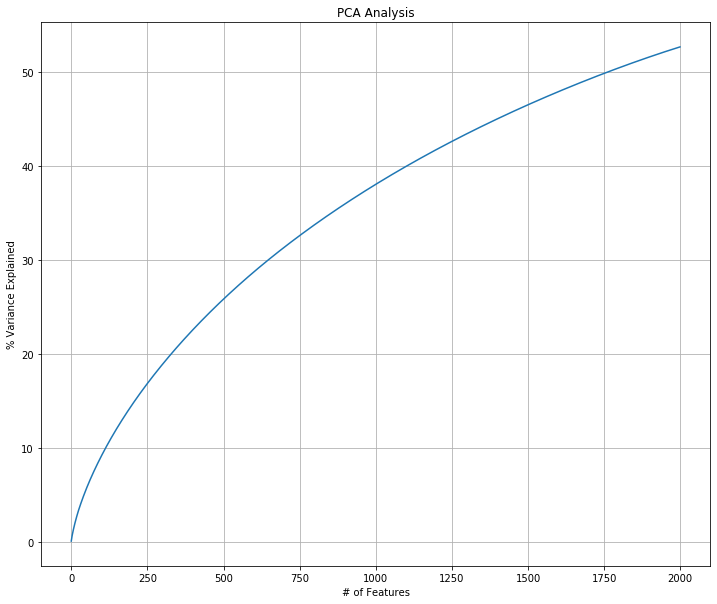

In [24]:
plt.figure(figsize=(12,10))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')

plt.plot(var)
plt.grid()

In [30]:
svd = TruncatedSVD(n_components=600, random_state=11)
X_train = svd.fit_transform(train_tfidf)
print(sum(svd.explained_variance_ratio_))

0.2938755835181106


In [31]:
X_train.shape, y_train.shape

((27148, 600), (27148,))

### Model Selection

In [32]:
# model selection: simple grid-search
parameters = {'n_estimators': [50, 100],
              'class_weight': ['balanced', None],
              'max_depth': [20, 35, 50]
             }
gridsearch = GridSearchCV(RandomForestClassifier(), parameters, cv=4, n_jobs=-1, verbose=10)
gridsearch.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:  6.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:  6.9min remaining:   47.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  7.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  7.6min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [33]:
gridsearch.best_params_, gridsearch.best_score_

({'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 100},
 0.32960070723441875)

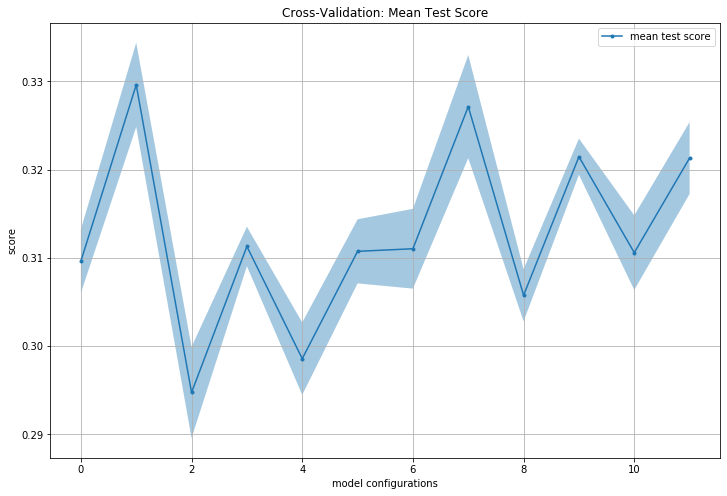

In [34]:
mean_score = gridsearch.cv_results_['mean_test_score']
std_score = gridsearch.cv_results_['std_test_score']

plt.figure(figsize=(12, 8))
plt.plot(mean_score, marker='.', label='mean test score')
plt.fill_between(range(len(mean_score)), 
                 mean_score - std_score,
                 mean_score + std_score,
                 alpha=0.4)
plt.title('Cross-Validation: Mean Test Score')
plt.xlabel('model configurations')
plt.ylabel('score')
plt.legend()
plt.grid()

In [35]:
best_hyp_param = gridsearch.best_params_

### Model train and test

In [36]:
movieclf = RandomForestClassifier(**best_hyp_param, random_state=15)

In [37]:
movieclf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=15, verbose=0, warm_start=False)

In [38]:
# transform test data using tfidf and svd objects fitted with train data
test_tfidf = tfidf.transform(test['text'])
X_test = svd.transform(test_tfidf)

In [39]:
y_test = test['genre'].values

In [40]:
X_test.shape, y_test.shape

((4178, 600), (4178,))

In [41]:
movieclf.score(X_test, y_test)

0.3635710866443274

In [45]:
y_pred = movieclf.predict(X_test)

In [42]:
# use confusion matrix to get an overall idea of performance
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=movieclf.classes_, 
             index=movieclf.classes_
            )

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
Action,2,0,0,23,0,2,43,0,0,4,3,3,1,0
Adventure,1,12,0,30,0,11,36,2,0,2,2,7,15,0
Animation,0,1,3,17,0,4,11,0,0,0,1,3,3,1
Comedy,2,10,0,597,2,90,260,11,0,20,23,189,10,0
Crime,4,2,0,20,0,3,30,0,0,1,9,6,1,0
Documentary,1,0,0,34,0,261,47,1,0,0,2,8,1,1
Drama,7,6,0,376,8,132,388,2,0,13,28,182,5,2
Family,0,0,0,63,0,9,36,4,0,1,0,13,1,0
Fantasy,0,3,0,3,0,4,3,0,0,1,0,1,0,0
Horror,0,1,0,47,0,10,52,0,0,48,18,10,8,3


In [46]:
P, R, F1, _ = precision_recall_fscore_support(y_test, y_pred)

/opt/anaconda3/envs/truelayer/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
pd.DataFrame(data=[P, R, F1], columns=movieclf.classes_, index=['precision', 'recall', 'f1'])

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
precision,0.086957,0.272727,1.000000,0.414871,0.0,0.448454,0.353370,0.166667,0.0,0.375000,0.263889,0.236181,0.337838,0.0
recall,0.024691,0.101695,0.068182,0.491763,0.0,0.733146,0.337685,0.031496,0.0,0.243655,0.205405,0.382114,0.240385,0.0
f1,0.038462,0.148148,0.127660,0.450057,0.0,0.556503,0.345349,0.052980,0.0,0.295385,0.231003,0.291925,0.280899,0.0


### Save classifier, tfidf and svd objects

In [43]:
mpath = 'models/'
dump(movieclf, mpath + 'movieclassifier.joblib')
dump(tfidf, mpath + 'tfidf.joblib')
dump(svd, mpath + 'svd.joblib');